# **AI-Powered Pneumonia Detection with Explainable Deep Learning**

This project focuses on leveraging deep learning techniques for the detection of pneumonia in chest X-ray images. The goal is to develop a robust classification model capable of distinguishing between normal and pneumonia-affected chest X-rays. The approach involves utilizing state-of-the-art Convolutional Neural Networks (CNNs) such as ResNet50, DenseNet121, EfficientNetB0, and MobileNetV2, which will be fine-tuned on a large dataset of chest X-ray images. The dataset used in this project includes labeled images of chest X-rays for both normal and pneumonia cases, and the model will be evaluated based on accuracy, precision, recall, and F1 score.

The key stages of the project include:

*   Data Preprocessing: Exploring and preparing the dataset, including resizing, normalizing, and augmenting the images.
*   Model Training: Training multiple deep learning models with transfer learning and fine-tuning pre-trained networks.
* Evaluation: Evaluating the models' performance and selecting the best-performing one for final deployment.

This project aims to provide valuable insights into the application of deep learning in the medical field, specifically for automated pneumonia detection, which can assist healthcare professionals in making faster and more accurate diagnoses.

**1. Project Setup & Environment Configuration:**

Install Libraries:

In [11]:
!pip install tensorflow keras matplotlib opencv-python
!pip install torch torchvision torchaudio
!pip install seaborn scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Verify CUDA & GPU Availability:

In [12]:
import torch
torch.cuda.is_available()  # Check if CUDA-enabled GPU is available


False

**2. Dataset Preparation:**

In [13]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable


In [14]:
# Load the chest X-ray pneumonia dataset from Hugging Face
from datasets import load_dataset

# 1. Load the dataset
hf_dataset = load_dataset('hf-vision/chest-xray-pneumonia')

# Print dataset details to understand structure
print(hf_dataset)

# Sample of the training data
print(hf_dataset['train'][0])


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5216
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 16
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=2090x1858 at 0x19DCF00FCB0>, 'label': 0}


**3. Dataset Exploration**

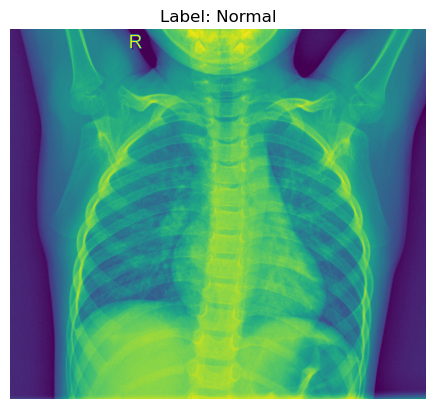

In [15]:
import matplotlib.pyplot as plt

# Sample Image from the dataset
image, label = hf_dataset['train'][0]['image'], hf_dataset['train'][0]['label']

# Display the image
plt.imshow(image)
plt.title(f"Label: {'Pneumonia' if label == 1 else 'Normal'}")
plt.axis('off')  # Hide axis
plt.show()



**4. Data Preprocessing**

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset

# 1) Define two distinct pipelines
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),        # ensure 3‐ch
    transforms.RandomHorizontalFlip(),                  # flip
    # transforms.RandomRotation(30),                      # rotate
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),# zoom/crop
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),                              # to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # normalize
                         std =[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# 2) Custom Dataset that applies whichever transform you pass
class ChestXrayDataset(Dataset):
    def __init__(self, hf_split, transform=None):
        self.split     = hf_split
        self.transform = transform

    def __len__(self):
        return len(self.split)

    def __getitem__(self, idx):
        item  = self.split[idx]
        image = item['image']
        label = item['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# 3) Load HF dataset & wrap in our PyTorch Dataset
hf = load_dataset('hf-vision/chest-xray-pneumonia')
train_ds = ChestXrayDataset(hf['train'],      transform=train_transform)
val_ds   = ChestXrayDataset(hf['validation'], transform=eval_transform)
test_ds  = ChestXrayDataset(hf['test'],       transform=eval_transform)

# 4) DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32)
test_loader  = DataLoader(test_ds,  batch_size=32)


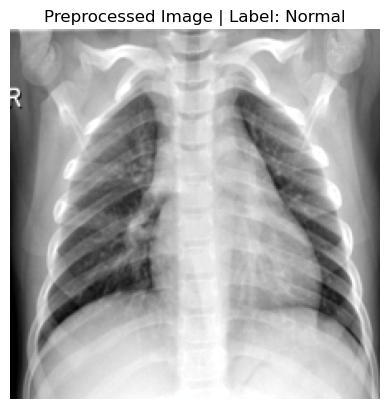

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Get a preprocessed image from the training dataset
img_tensor, label = train_ds[5]  # Change index if needed

# De-normalize the image for visualization
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
img = img_tensor.permute(1, 2, 0).numpy()  # CHW -> HWC
img = (img * std) + mean
img = np.clip(img, 0, 1)

# Display the image
plt.imshow(img)
plt.title(f"Preprocessed Image | Label: {'Pneumonia' if label == 1 else 'Normal'}")
plt.axis('off')
plt.show()


In [18]:
from collections import Counter

# Helper function to count labels in a dataset
def count_labels(dataset, split_name):
    labels = [dataset[i][1] for i in range(len(dataset))]
    label_counts = Counter(labels)
    print(f"{split_name} - Label 0: {label_counts.get(0, 0)}, Label 1: {label_counts.get(1, 0)}")

# Count labels in each split
count_labels(train_ds, "Train")
count_labels(val_ds, "Validation")
count_labels(test_ds, "Test")

Train - Label 0: 1341, Label 1: 3875
Validation - Label 0: 8, Label 1: 8
Test - Label 0: 234, Label 1: 390


In [36]:
print(test_ds[0])

(tensor([[[-1.6042, -1.5699, -1.5699,  ..., -1.5528, -1.5699, -1.6042],
         [-1.6042, -1.5699, -1.5699,  ..., -1.5870, -1.5699, -1.6042],
         [-1.6213, -1.5699, -1.5699,  ..., -1.5870, -1.5699, -1.6213],
         ...,
         [-1.6555, -1.6042, -1.6213,  ..., -1.5528, -1.5528, -1.6042],
         [-1.6555, -1.6042, -1.6213,  ..., -1.5528, -1.5357, -1.5870],
         [-1.6555, -1.6042, -1.6213,  ..., -1.5528, -1.5528, -1.5870]],

        [[-1.5105, -1.4755, -1.4755,  ..., -1.4580, -1.4755, -1.5105],
         [-1.5105, -1.4755, -1.4755,  ..., -1.4930, -1.4755, -1.5105],
         [-1.5280, -1.4755, -1.4755,  ..., -1.4930, -1.4755, -1.5280],
         ...,
         [-1.5630, -1.5105, -1.5280,  ..., -1.4580, -1.4580, -1.5105],
         [-1.5630, -1.5105, -1.5280,  ..., -1.4580, -1.4405, -1.4930],
         [-1.5630, -1.5105, -1.5280,  ..., -1.4580, -1.4580, -1.4930]],

        [[-1.2816, -1.2467, -1.2467,  ..., -1.2293, -1.2467, -1.2816],
         [-1.2816, -1.2467, -1.2467,  ..., -

#Balancing Sampling#

In [19]:
from torch.utils.data import WeightedRandomSampler
import numpy as np

# Step 1: Get all labels from your training dataset
train_labels = [train_ds[i][1] for i in range(len(train_ds))]

# Step 2: Compute class counts
class_counts = Counter(train_labels)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# Step 3: Create a list of weights for each sample
sample_weights = [class_weights[label] for label in train_labels]

# Step 4: Define the sampler
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(train_ds),
                                replacement=True)

balanced_train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)


### 6. Model Architecture

In this project, we're using a **pre-trained ResNet50 model** and fine-tuning it for pneumonia detection using chest X-ray images.

- **ResNet50** is a deep convolutional neural network (CNN) designed to avoid the vanishing gradient problem by using **residual blocks**. These blocks allow the network to learn deeper representations without losing information.
- The ResNet50 model is pre-trained on **ImageNet**, which means it has learned to recognize features from millions of images. We will use these pre-trained weights and modify the final layers to suit our task of binary classification (Pneumonia vs. Normal).

#### Key Components:
1. **Convolutional Layers**: These layers extract key features from the input images, such as edges, textures, and patterns.
2. **Residual Blocks**: These blocks allow the model to skip certain layers to prevent the vanishing gradient problem.
3. **Global Average Pooling**: This step reduces the spatial dimensions and retains the most important features.
4. **Fully Connected Layer**: This new layer maps the extracted features to the final output, which is a single binary prediction.
5. **Sigmoid Activation**: Used for binary classification, it outputs a probability value between 0 and 1.


#### Code: Pneumonia Detection Model Using ResNet50

In [20]:
import torch
import torch.nn as nn
import torchvision.models as models

class PneumoniaDetectionModel(nn.Module):
    def __init__(self, backbone_name='resnet18', freeze_all=True, fine_tune_layers=0):
        super(PneumoniaDetectionModel, self).__init__()

        backbones = {
            'resnet18': models.resnet18,
            'resnet34': models.resnet34,
            'resnet50': models.resnet50,
            'densenet121': models.densenet121,
            'efficientnet_b0': models.efficientnet_b0,
            'mobilenet_v2': models.mobilenet_v2,
            'vgg16': models.vgg16
        }

        if backbone_name not in backbones:
            raise ValueError(f"Backbone '{backbone_name}' not supported. Choose from {list(backbones.keys())}")

        if 'efficientnet' in backbone_name:
            self.model = backbones[backbone_name](weights=models.EfficientNet_B0_Weights.DEFAULT)
        elif 'resnet' in backbone_name:
            self.model = backbones[backbone_name](weights=models.ResNet18_Weights.DEFAULT if backbone_name == 'resnet18' else
                                                                 models.ResNet34_Weights.DEFAULT if backbone_name == 'resnet34' else
                                                                 models.ResNet50_Weights.DEFAULT)
        elif 'densenet' in backbone_name:
            self.model = backbones[backbone_name](weights=models.DenseNet121_Weights.DEFAULT)
        elif 'mobilenet' in backbone_name:
            self.model = backbones[backbone_name](weights=models.MobileNet_V2_Weights.DEFAULT)
        elif 'vgg' in backbone_name:
            self.model = backbones[backbone_name](weights=models.VGG16_Weights.DEFAULT)

        if freeze_all:
            for param in self.model.parameters():
                param.requires_grad = False

        if fine_tune_layers > 0:
            for param in list(self.model.parameters())[-fine_tune_layers:]:
                param.requires_grad = True

        if 'resnet' in backbone_name:
            self.model.fc = nn.Linear(self.model.fc.in_features, 1)
        elif 'densenet' in backbone_name:
            self.model.classifier = nn.Linear(self.model.classifier.in_features, 1)
        elif 'efficientnet' in backbone_name:
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)
        elif 'mobilenet' in backbone_name:
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)
        elif 'vgg' in backbone_name:
            self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, 1)

    def forward(self, x):
        x = self.model(x)
        return x  # Raw logits (use BCEWithLogitsLoss)


### 🔹 Training Loop

In each epoch, we perform the following steps:

1. **Forward pass**: We pass the input data through the model.
2. **Loss computation**: The model’s predictions are compared with the true labels using the binary cross-entropy loss function.
3. **Backpropagation**: The gradients of the loss are calculated and propagated back to update the model's weights.
4. **Evaluation**: After each epoch, we evaluate the model on the validation set to track progress.


In [21]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, loss_fn, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_preds / total_preds

        model.eval()
        val_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images).squeeze()
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct_preds += (preds == labels).sum().item()
                val_total_preds += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = val_correct_preds / val_total_preds
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}, Acc: {epoch_accuracy:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("✔️  Saved best model.")

    return model


### 🔹 8. Model Evaluation and Testing

After training the model, we evaluate its performance on the test set. This helps us understand how well the model generalizes to unseen data.

#### 🧪 Testing

The testing phase involves using the trained model to predict the labels of the test set. We then compare these predictions with the actual labels and calculate performance metrics like accuracy, precision, recall, and F1 score.

In [22]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load("best_model.pth"))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images).squeeze()
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels


### 🔹 9. Confusion Matrix and Classification Report

To evaluate the model's performance more thoroughly, we compute the confusion matrix and classification report. These metrics help us understand how many false positives and false negatives the model produces.

#### 📊 Code: Plot Confusion Matrix and Classification Report


In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal", "Pneumonia"],
                yticklabels=["Normal", "Pneumonia"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.tight_layout()
    plt.show()



🔍 Testing model: efficientnet_b0
Epoch 1/10 - Train Loss: 0.5770, Acc: 0.7218 | Val Loss: 0.7277, Acc: 0.5000
✔️  Saved best model.
Epoch 2/10 - Train Loss: 0.4781, Acc: 0.7715 | Val Loss: 0.6477, Acc: 0.5000
✔️  Saved best model.
Epoch 3/10 - Train Loss: 0.4181, Acc: 0.8311 | Val Loss: 0.5824, Acc: 0.6250
✔️  Saved best model.
Epoch 4/10 - Train Loss: 0.3706, Acc: 0.8691 | Val Loss: 0.5552, Acc: 0.6875
✔️  Saved best model.
Epoch 5/10 - Train Loss: 0.3412, Acc: 0.8911 | Val Loss: 0.5232, Acc: 0.6875
✔️  Saved best model.
Epoch 6/10 - Train Loss: 0.3213, Acc: 0.8923 | Val Loss: 0.5046, Acc: 0.6875
✔️  Saved best model.
Epoch 7/10 - Train Loss: 0.2952, Acc: 0.9089 | Val Loss: 0.4808, Acc: 0.8125
✔️  Saved best model.
Epoch 8/10 - Train Loss: 0.2832, Acc: 0.9066 | Val Loss: 0.4722, Acc: 0.8125
✔️  Saved best model.
Epoch 9/10 - Train Loss: 0.2721, Acc: 0.9124 | Val Loss: 0.4560, Acc: 0.8125
✔️  Saved best model.
Epoch 10/10 - Train Loss: 0.2619, Acc: 0.9135 | Val Loss: 0.4471, Acc: 0.81

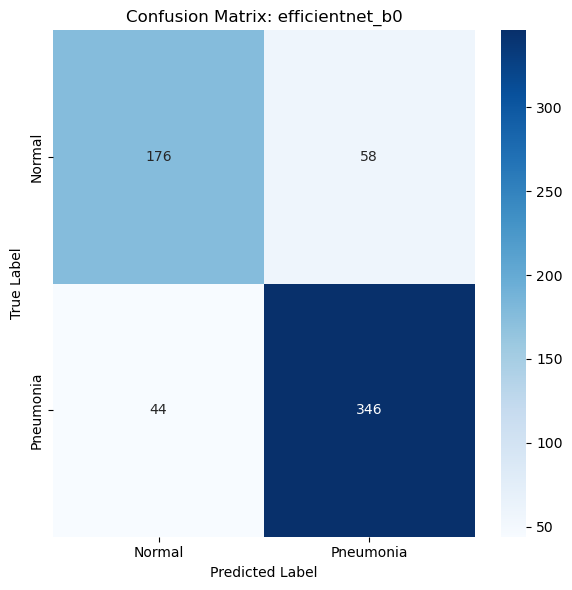

✅ Accuracy for efficientnet_b0: 0.8365

🔍 Testing model: densenet121
Epoch 1/10 - Train Loss: 0.5901, Acc: 0.7092 | Val Loss: 0.7106, Acc: 0.5000
✔️  Saved best model.
Epoch 2/10 - Train Loss: 0.4979, Acc: 0.7473 | Val Loss: 0.6236, Acc: 0.5000
✔️  Saved best model.
Epoch 3/10 - Train Loss: 0.4370, Acc: 0.7755 | Val Loss: 0.5367, Acc: 0.6250
✔️  Saved best model.
Epoch 4/10 - Train Loss: 0.3927, Acc: 0.8165 | Val Loss: 0.4646, Acc: 0.8750
✔️  Saved best model.
Epoch 5/10 - Train Loss: 0.3473, Acc: 0.8635 | Val Loss: 0.4390, Acc: 0.7500
✔️  Saved best model.
Epoch 6/10 - Train Loss: 0.3290, Acc: 0.8748 | Val Loss: 0.4092, Acc: 0.7500
✔️  Saved best model.
Epoch 7/10 - Train Loss: 0.3097, Acc: 0.8894 | Val Loss: 0.3811, Acc: 0.8750
✔️  Saved best model.
Epoch 8/10 - Train Loss: 0.2858, Acc: 0.9026 | Val Loss: 0.3762, Acc: 0.8125
✔️  Saved best model.
Epoch 9/10 - Train Loss: 0.2768, Acc: 0.9034 | Val Loss: 0.3622, Acc: 0.8125
✔️  Saved best model.
Epoch 10/10 - Train Loss: 0.2622, Acc: 0

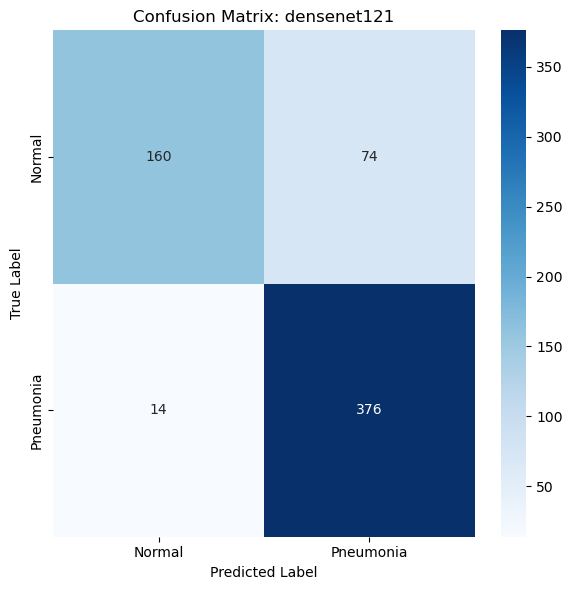

✅ Accuracy for densenet121: 0.8590

🔍 Testing model: resnet18
Epoch 1/10 - Train Loss: 0.5691, Acc: 0.7375 | Val Loss: 0.7219, Acc: 0.5000
✔️  Saved best model.
Epoch 2/10 - Train Loss: 0.4610, Acc: 0.7726 | Val Loss: 0.6050, Acc: 0.6250
✔️  Saved best model.
Epoch 3/10 - Train Loss: 0.3947, Acc: 0.8211 | Val Loss: 0.5240, Acc: 0.6250
✔️  Saved best model.
Epoch 4/10 - Train Loss: 0.3491, Acc: 0.8553 | Val Loss: 0.4549, Acc: 0.7500
✔️  Saved best model.
Epoch 5/10 - Train Loss: 0.3244, Acc: 0.8710 | Val Loss: 0.4387, Acc: 0.7500
✔️  Saved best model.
Epoch 6/10 - Train Loss: 0.3008, Acc: 0.8831 | Val Loss: 0.4385, Acc: 0.6875
✔️  Saved best model.
Epoch 7/10 - Train Loss: 0.2954, Acc: 0.8815 | Val Loss: 0.4218, Acc: 0.7500
✔️  Saved best model.
Epoch 8/10 - Train Loss: 0.2751, Acc: 0.8886 | Val Loss: 0.4230, Acc: 0.7500
Epoch 9/10 - Train Loss: 0.2644, Acc: 0.9009 | Val Loss: 0.3971, Acc: 0.7500
✔️  Saved best model.
Epoch 10/10 - Train Loss: 0.2561, Acc: 0.8990 | Val Loss: 0.4081, Acc

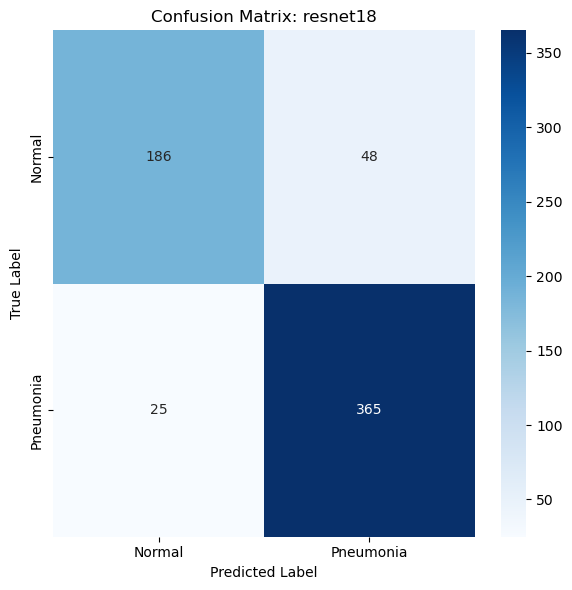

✅ Accuracy for resnet18: 0.8830

🔍 Testing model: mobilenet_v2
Epoch 1/10 - Train Loss: 0.5284, Acc: 0.7414 | Val Loss: 0.7869, Acc: 0.5000
✔️  Saved best model.
Epoch 2/10 - Train Loss: 0.4579, Acc: 0.7464 | Val Loss: 0.7113, Acc: 0.5625
✔️  Saved best model.
Epoch 3/10 - Train Loss: 0.4081, Acc: 0.7740 | Val Loss: 0.6815, Acc: 0.5625
✔️  Saved best model.
Epoch 4/10 - Train Loss: 0.3754, Acc: 0.8229 | Val Loss: 0.6153, Acc: 0.6250
✔️  Saved best model.
Epoch 5/10 - Train Loss: 0.3445, Acc: 0.8574 | Val Loss: 0.6065, Acc: 0.6250
✔️  Saved best model.
Epoch 6/10 - Train Loss: 0.3253, Acc: 0.8677 | Val Loss: 0.5742, Acc: 0.6250
✔️  Saved best model.
Epoch 7/10 - Train Loss: 0.3147, Acc: 0.8785 | Val Loss: 0.5518, Acc: 0.6875
✔️  Saved best model.
Epoch 8/10 - Train Loss: 0.3077, Acc: 0.8777 | Val Loss: 0.5234, Acc: 0.6875
✔️  Saved best model.
Epoch 9/10 - Train Loss: 0.2873, Acc: 0.8936 | Val Loss: 0.5022, Acc: 0.7500
✔️  Saved best model.
Epoch 10/10 - Train Loss: 0.2786, Acc: 0.9003 

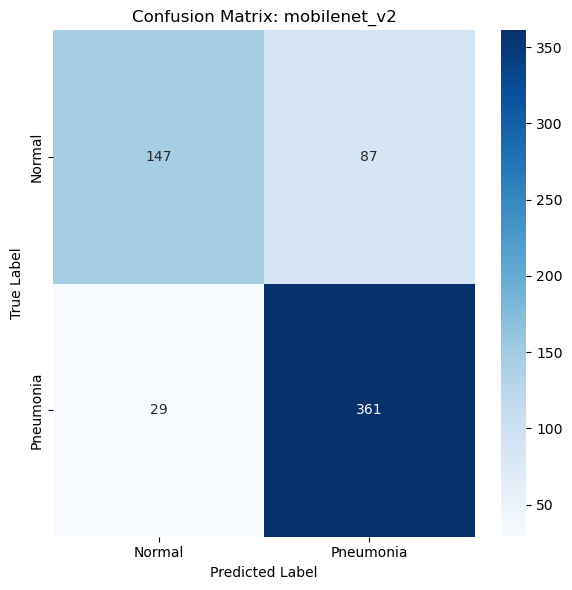

✅ Accuracy for mobilenet_v2: 0.8141

🔍 Testing model: vgg16
Epoch 1/10 - Train Loss: 0.4961, Acc: 0.7579 | Val Loss: 0.4890, Acc: 0.8750
✔️  Saved best model.
Epoch 2/10 - Train Loss: 0.3661, Acc: 0.8403 | Val Loss: 0.4048, Acc: 0.8750
✔️  Saved best model.
Epoch 3/10 - Train Loss: 0.3256, Acc: 0.8587 | Val Loss: 0.3743, Acc: 0.8750
✔️  Saved best model.
Epoch 4/10 - Train Loss: 0.3023, Acc: 0.8738 | Val Loss: 0.3621, Acc: 0.8750
✔️  Saved best model.
Epoch 5/10 - Train Loss: 0.2848, Acc: 0.8857 | Val Loss: 0.3386, Acc: 0.8750
✔️  Saved best model.
Epoch 6/10 - Train Loss: 0.2701, Acc: 0.8911 | Val Loss: 0.3348, Acc: 0.8750
✔️  Saved best model.
Epoch 7/10 - Train Loss: 0.2621, Acc: 0.8942 | Val Loss: 0.3142, Acc: 0.8750
✔️  Saved best model.
Epoch 8/10 - Train Loss: 0.2570, Acc: 0.8934 | Val Loss: 0.3161, Acc: 0.8750
Epoch 9/10 - Train Loss: 0.2566, Acc: 0.8921 | Val Loss: 0.3210, Acc: 0.8750
Epoch 10/10 - Train Loss: 0.2469, Acc: 0.9024 | Val Loss: 0.3129, Acc: 0.8750
✔️  Saved best 

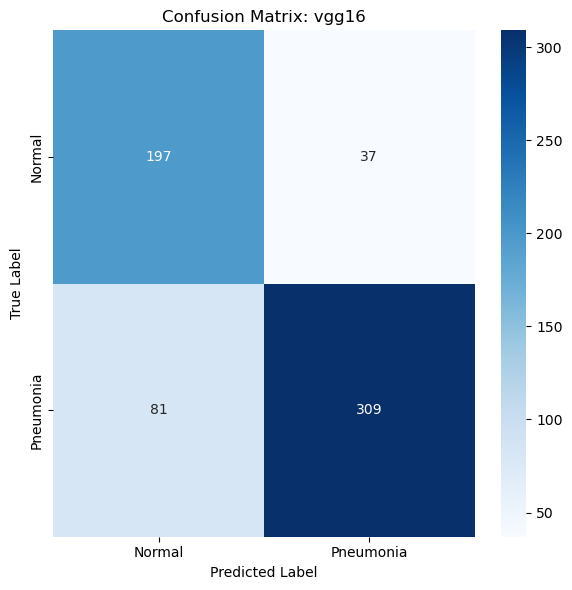

✅ Accuracy for vgg16: 0.8109

🏆 Best model: resnet18 with accuracy 0.8830


In [24]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np

backbones = ['efficientnet_b0','densenet121', 'resnet18', 'mobilenet_v2', 'vgg16']
results = {}

for backbone in backbones:
    print(f"\n🔍 Testing model: {backbone}")

    model = PneumoniaDetectionModel(backbone_name=backbone)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    trained_model = train_model(model, train_loader, val_loader, optimizer, scheduler, loss_fn, epochs=10)
    torch.save(trained_model.state_dict(), f"{backbone}.pth")

    preds, labels = evaluate_model(trained_model, test_loader)
    acc = (np.array(preds) == np.array(labels)).mean()
    results[backbone] = acc

    cm = confusion_matrix(labels, preds)
    report = classification_report(labels, preds, target_names=["Normal", "Pneumonia"])

    print(f"\n📊 Classification Report for {backbone}:\n{report}")
    plot_confusion_matrix(cm, backbone)
    print(f"✅ Accuracy for {backbone}: {acc:.4f}")

best_model = max(results, key=results.get)
print(f"\n🏆 Best model: {best_model} with accuracy {results[best_model]:.4f}")



In [25]:
print(results)
print(best_model)


{'efficientnet_b0': 0.8365384615384616, 'densenet121': 0.8589743589743589, 'resnet18': 0.8830128205128205, 'mobilenet_v2': 0.8141025641025641, 'vgg16': 0.8108974358974359}
resnet18


In [26]:

!pip install grad-cam
!pip install opencv-python



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


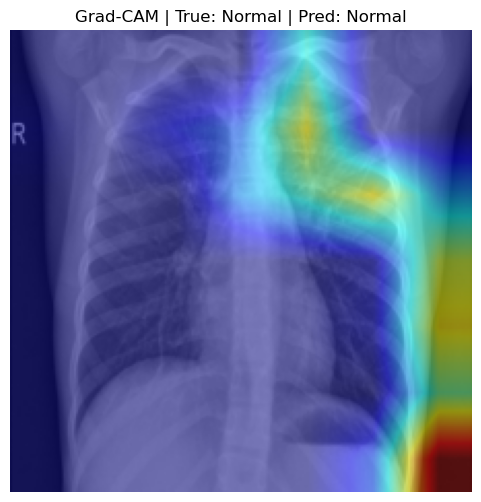

In [55]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load your model (Replace with your actual model file)
# Assuming PneumoniaDetectionModel is defined in your_model_file
# from your_model_file import PneumoniaDetectionModel

# 1. Load best model (ResNet18)
model_gc = PneumoniaDetectionModel(backbone_name='resnet18', freeze_all=False)
model_gc.load_state_dict(torch.load("resnet18.pth", map_location=device))
model_gc.to(device).eval()

# 2. Pick image from test dataset
img_tensor, label = test_ds[1]  # Change index as needed
input_tensor = img_tensor.unsqueeze(0).to(device)

# 3. De-normalize the image for display
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
img_np = (img_np * std) + mean
img_np = np.clip(img_np, 0, 1)  # Ensure values stay within [0, 1]

# 4. Select target layer for Grad-CAM (ResNet18: layer4[-1])
target_layer = model_gc.model.layer4[-1]  # Update this based on the model's architecture

# 5. Set up Grad-CAM
cam = GradCAM(model=model_gc, target_layers=[target_layer])
targets = [ClassifierOutputTarget(0)]  # Binary classifier (sigmoid output)

# 6. Generate Grad-CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# 7. Overlay Grad-CAM on the image
cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

# ✅ Predict label using the model
with torch.no_grad():
    output = model_gc(input_tensor)
    pred_label = (output > 0.5).float().item()  # Convert sigmoid output to 0 or 1

# ✅ Prepare the title with predicted and true labels
true_str = 'Pneumonia' if label == 1 else 'Normal'
pred_str = 'Pneumonia' if pred_label == 1 else 'Normal'

# 8. Plot Grad-CAM with the true and predicted labels
plt.figure(figsize=(6, 6))
plt.imshow(cam_image)
plt.title(f"Grad-CAM | True: {true_str} | Pred: {pred_str}")
plt.axis('off')
plt.show()


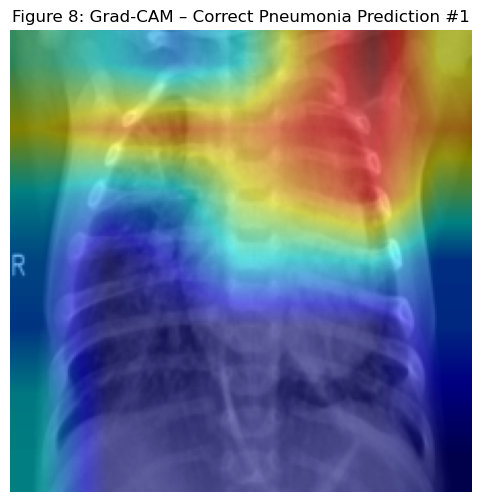

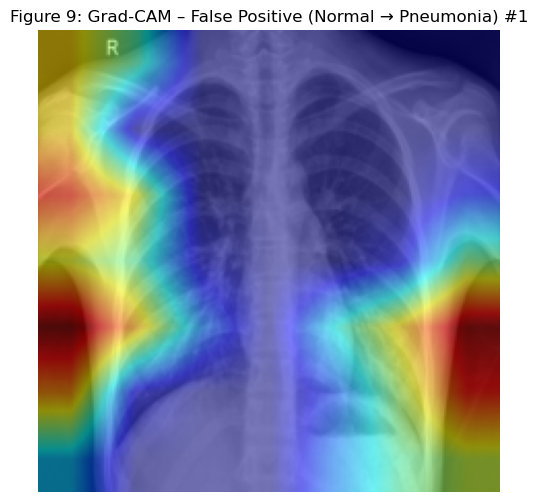

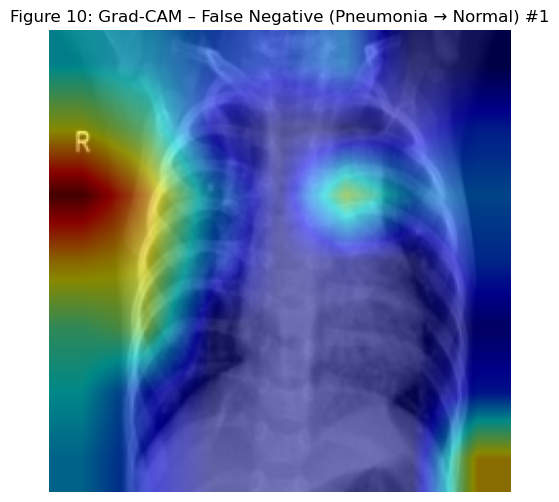

In [67]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load your model (Replace with your actual model file)
# Assuming PneumoniaDetectionModel is defined in your_model_file
# from your_model_file import PneumoniaDetectionModel

# 1. Load best model (ResNet18)
model_gc = PneumoniaDetectionModel(backbone_name='resnet18', freeze_all=False)
model_gc.load_state_dict(torch.load("resnet18.pth", map_location=device))
model_gc.to(device).eval()

# ✅ Prepare placeholders for storing the images of different cases
correct_pneumonia_images = []
false_positive_images = []
false_negative_images = []

# 2. Loop through the dataset
for idx in range(len(test_ds)):  # Iterate through test dataset
    img_tensor, label = test_ds[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    # 3. De-normalize the image for display
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * std) + mean
    img_np = np.clip(img_np, 0, 1)  # Ensure values stay within [0, 1]

    # 4. Select target layer for Grad-CAM (ResNet18: layer4[-1])
    target_layer = model_gc.model.layer4[-1]  # Update this based on the model's architecture

    # 5. Set up Grad-CAM
    cam = GradCAM(model=model_gc, target_layers=[target_layer])
    targets = [ClassifierOutputTarget(0)]  # Binary classifier (sigmoid output)

    # 6. Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # 7. Overlay Grad-CAM on the image
    cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    # ✅ Predict label using the model
    with torch.no_grad():
        output = model_gc(input_tensor)
        pred_label = (output > 0.5).float().item()  # Convert sigmoid output to 0 or 1

    # ✅ Prepare the title with predicted and true labels
    true_str = 'Pneumonia' if label == 1 else 'Normal'
    pred_str = 'Pneumonia' if pred_label == 1 else 'Normal'

    if true_str == 'Pneumonia' and pred_str == 'Pneumonia' and len(correct_pneumonia_images) == 0:
        correct_pneumonia_images.append(cam_image)

    elif true_str == 'Normal' and pred_str == 'Pneumonia' and len(false_positive_images) == 0:
        false_positive_images.append(cam_image)

    elif true_str == 'Pneumonia' and pred_str == 'Normal' and len(false_negative_images) == 0:
        false_negative_images.append(cam_image)

    # ✅ Break the loop if all 3 cases are captured
    if (len(correct_pneumonia_images) > 0 and
        len(false_positive_images) > 0 and
        len(false_negative_images) > 0):
        break


# Display the Grad-CAM images for each case
# ✅ Case 1: Correct Pneumonia Prediction
for i, img in enumerate(correct_pneumonia_images):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Figure 8: Grad-CAM – Correct Pneumonia Prediction #{i + 1}")
    plt.axis('off')
    plt.show()

# ✅ Case 2: False Positive (Normal → Pneumonia)
for i, img in enumerate(false_positive_images):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Figure 9: Grad-CAM – False Positive (Normal → Pneumonia) #{i + 1}")
    plt.axis('off')
    plt.show()

# ✅ Case 3: False Negative (Pneumonia → Normal)
for i, img in enumerate(false_negative_images):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Figure 10: Grad-CAM – False Negative (Pneumonia → Normal) #{i + 1}")
    plt.axis('off')
    plt.show()
